# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2, os

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist

import tensorflow as tf
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(12,4))
    plt.plot(history['loss'], label='train_err', marker = ',')
    plt.plot(history['val_loss'], label='val_err', marker = ',')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
tf.config.experimental.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# CNN 맛보기

## 가벼운 실습

`-` 이미지의 각 **영역에 대한 특징들을** 추출하는 것임

`-` 아래 그림에서 4가지만 기억하자

1. input shape : [가로 x 세로 x 채널(`흑백이면 1, 컬러면 3`)]

2. Convolution layer : 이미지의 지역적인 특성들을 추출

3. Max pooling layer : 뽑는 특징을 요약 (최대값, 필터)

4. Flatten : Dense layer에 연결하기 위해 펼침

![](https://github.com/DA4BAM/image/blob/main/cnn_mnist3.png?raw=true)

In [4]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
x_train = x_train/255
x_val = x_val/255

In [6]:
x_train.shape

(60000, 28, 28)

<center><img src = "https://github.com/DA4BAM/image/blob/main/cnn_mnist3.png?raw=true"  width = 500></center>

`-` 위 모델을 설계해보자

In [7]:
clear_session()
model3 = Sequential([
                    Conv2D(32, kernel_size = (3, 3), input_shape =(28, 28, 1), padding='same', activation =  "relu"), ## 지역적인 특징 32개 도출
                     MaxPooling2D(pool_size = (2, 2), strides=2), ## 특징이 너무 많으니 좀 줄여
                     Conv2D (64, kernel_size = (3, 3), padding='same', activation = "relu" ), ## 다시, 특징 64개 추출
                     MaxPooling2D (pool_size = (2, 2), strides=2), ## 다시 반으로 줄임
                     Flatten (), ## Dense에 전달하기 위해 펼침
                     Dense(128, activation =  "relu"), ## 128개의 node를 가진 Dense
                     Dense(10, activation = "softmax") ## output =10, target class가 총 10개 이므로!
])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

`-` 학습

In [8]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

In [9]:
history = model3.fit(x_train, y_train, epochs = 10, validation_split=0.2).history

Epoch 1/10
1500/1500 [==============================] - 25s 6ms/step - loss: 0.1369 - val_loss: 0.0552
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0448 - val_loss: 0.0453
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0305 - val_loss: 0.0381
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0216 - val_loss: 0.0352
Epoch 5/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0169 - val_loss: 0.0358
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0123 - val_loss: 0.0419
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0105 - val_loss: 0.0417
Epoch 8/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0088 - val_loss: 0.0401
Epoch 9/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0061 - val_loss: 0.0587
Epoch 10/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.00

`-` train-loss 시각화

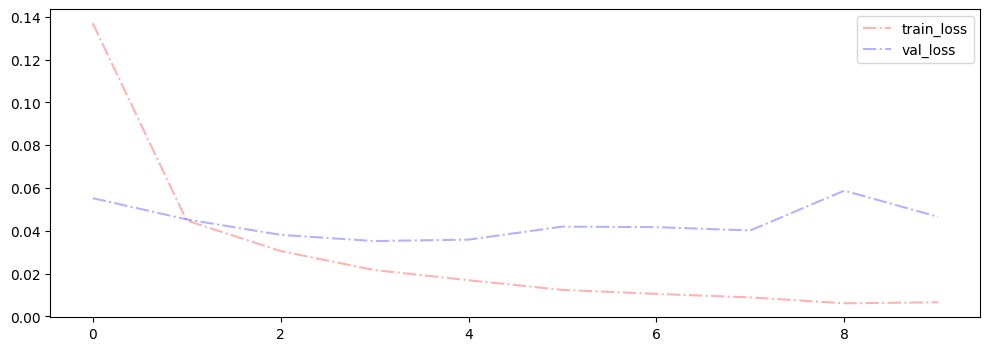

In [10]:
plt.figure(figsize = (12, 4))
plt.plot(history["loss"], "-.r", label = "train_loss", alpha = 0.3)
plt.plot(history["val_loss"], "-.b", label = "val_loss", alpha = 0.3)
plt.legend()
plt.show()

## 모델링 1

| Layer (type) | Output Shape  | Param #   |
|---- |----|----|
| conv2d (Conv2D)  |  (None, 28, 28, 16) | 160       |
| max_pooling2d |  (None, 14, 14, 16) |      0         |
| flatten (Flatten) | (None, 3136)   |           0         |
| **dense (Dense)** |    **(None, 128)**   |            401536    |
| dense_1 (Dense) |    (None, 10)   |             1290     |

In [11]:
clear_session()

model = Sequential([Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same', strides = 1, activation="relu"  ),
                    MaxPooling2D(pool_size=(2, 2), strides=2),
                    Flatten(),
                    Dense( 128, activation = "relu"),
                    Dense(10, activation = "softmax" )
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 402986 (1.54 MB)
Trainable params: 402986 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history = model.fit(x_train, y_train, epochs = 10,
                    validation_split=0.2).history

Epoch 1/10
1500/1500 [==============================] - 6s 3ms/step - loss: 0.2019 - val_loss: 0.0923
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0684 - val_loss: 0.0688
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0427 - val_loss: 0.0589
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0296 - val_loss: 0.0525
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0206 - val_loss: 0.0571
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0149 - val_loss: 0.0538
Epoch 7/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0107 - val_loss: 0.0614
Epoch 8/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0074 - val_loss: 0.0704
Epoch 9/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0070 - val_loss: 0.0637
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.005

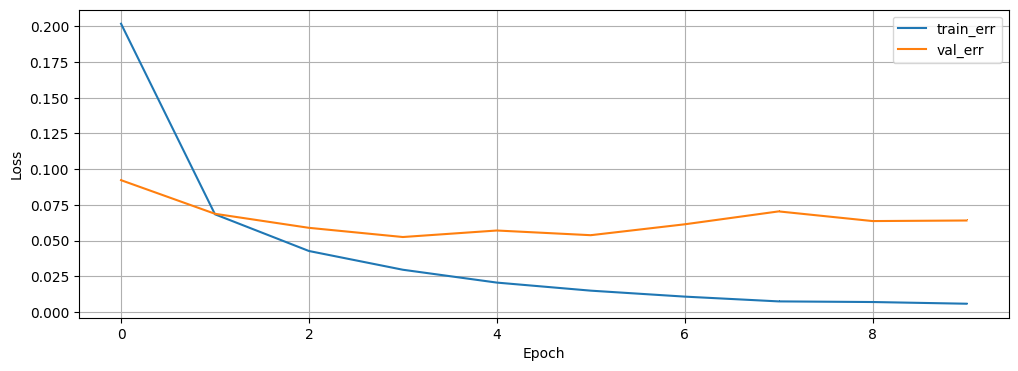

In [13]:
dl_history_plot(history)

In [14]:
pred = model.predict(x_val)
pred_1 = pred.argmax(axis=1)

313/313 [==============================] - 1s 2ms/step


In [15]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(classification_report(y_val, pred_1))

0.9866
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## 모델링 2

| Layer (type) | Output Shape  | Param #   |
|---- |----|----|
| conv2d (Conv2D)  |  (None, 28, 28, **32**) | 320       |
| max_pooling2d |  (None, 14, 14, 32) |      0         |
| flatten (Flatten) | (None, 6272)   |           0         |
| dense (Dense) |    (None, 128)   |            802944        |
| dense_1 (Dense) |    (None, 10)   |             1290     |

In [16]:
clear_session()
model = Sequential([ Conv2D(32, kernel_size  =(3, 3), input_shape = (28, 28, 1), padding='same', strides = 1, activation = "relu"  ),
                     MaxPooling2D(pool_size =(2, 2), strides=2),
                     Flatten (),
                     Dense(128, activation = "relu" ),
                     Dense(10, activation= "softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 804554 (3.07 MB)
Trainable params: 804554 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

history = model.fit(x_train, y_train, epochs = 10,
                    validation_split=0.2).history

Epoch 1/10
1500/1500 [==============================] - 6s 3ms/step - loss: 0.1732 - val_loss: 0.0848
Epoch 2/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0571 - val_loss: 0.0609
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0370 - val_loss: 0.0557
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0234 - val_loss: 0.0528
Epoch 5/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0167 - val_loss: 0.0600
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0119 - val_loss: 0.0634
Epoch 7/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0089 - val_loss: 0.0663
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0063 - val_loss: 0.0588
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0059 - val_loss: 0.0903
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.004

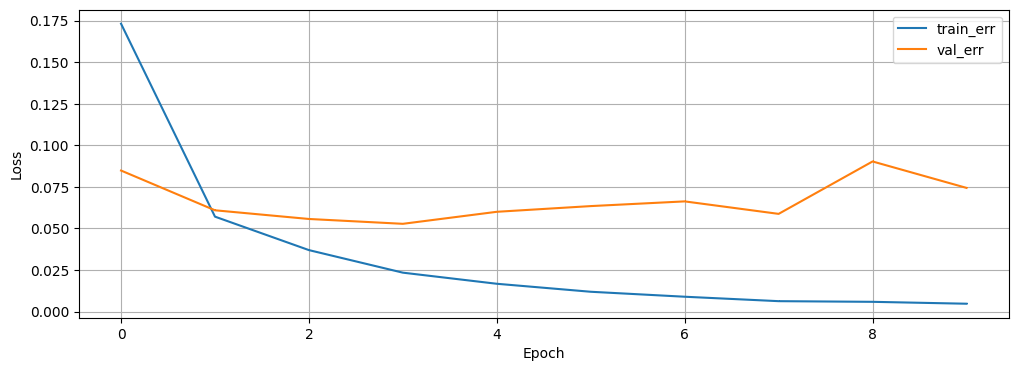

In [18]:
dl_history_plot(history)

In [19]:
pred = model.predict(x_val)
pred_1 = pred.argmax(axis=1)

313/313 [==============================] - 1s 2ms/step


In [20]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))
print('-'*60)
print(classification_report(y_val, pred_1))

0.9844
------------------------------------------------------------
[[ 976    0    0    1    0    0    3    0    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [   2    7 1019    1    1    0    1    1    0    0]
 [   1    0    3 1001    0    2    0    1    1    1]
 [   0    3    0    0  976    0    2    0    0    1]
 [   3    0    1   14    0  870    3    0    1    0]
 [   5    4    1    1    4    2  939    0    2    0]
 [   1   10   11    1    0    0    0 1000    5    0]
 [   5    1    2    2    1    0    1    1  958    3]
 [   4    4    0    3   17    1    0    5    3  972]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5   

## 틀린그림 찾아보기

<center><img src = "https://github.com/DA4BAM/image/blob/main/cnn_mnist3.png?raw=true"  width = 500></center>

`-` 위와 같이 설계한 모델을 가지고 틀린그림을 찾아보자.

`-` 코드를 이해하기보단 그냥 사용하자..

In [21]:
pred_1 = model3.predict(x_val).argmax(axis=1)

313/313 [==============================] - 1s 2ms/step


In [22]:
idx = (y_val != pred_1)
x_val_wr = x_val[idx]
y_val_wr = y_val[idx]
pred_wr = pred_1[idx]

x_val_wr = x_val_wr.reshape(-1,28,28)
print(x_val_wr.shape)

(94, 28, 28)


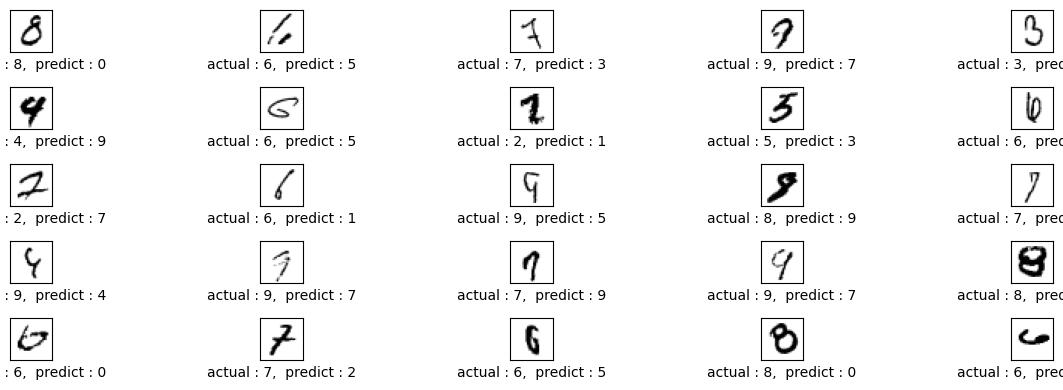

In [23]:
idx = rd.sample(range(x_val_wr.shape[0]),25)
x_temp = x_val_wr[idx]
y_temp = y_val_wr[idx]
p_temp = pred_wr[idx]

plt.figure(figsize=(14,4))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_temp[i], cmap=plt.cm.binary)
    plt.xlabel(f'actual : {y_temp[i]},  predict : {p_temp[i]}')
plt.tight_layout()
plt.show()

## 모델 저장하기

`-` model save

In [24]:
model3.save('mnist_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


`-` 저장된 경로 : /content/mnist_model.h5

* 드라이브 마운트를 안해서... 드라이브에선 저장된 모델을 찾을 수 없다.. 다음부턴 드라이브 마운트를 꼭하자!

`-` 다시 불러와서 저장

In [25]:
from keras.models import load_model
m3 = load_model('mnist_model.h5')

`-` 예측

In [26]:
pred = m3.predict(x_val)
pred_1 = pred.argmax(axis=1)

313/313 [==============================] - 1s 2ms/step


`-` 결과 report

In [27]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(classification_report(y_val, pred_1))

0.9906
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



***

# RNN 맛보기

In [28]:
from keras.layers import Dense, SimpleRNN, LSTM

In [29]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

## (1) 데이터 이해 및 정리

In [30]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


`-` 온도의 흐름을 살펴보자!

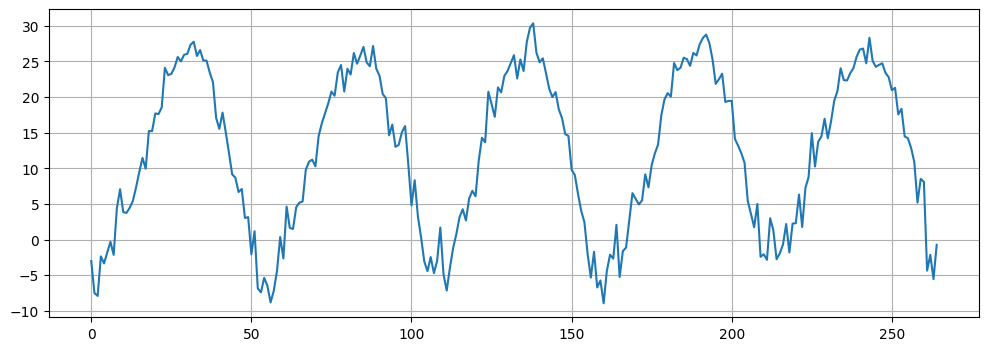

In [31]:
plt.figure(figsize = (12,4))
plt.plot(data.AvgTemp)
plt.grid()
plt.show()

`-` y만들기

* 우리가 하려는거 저번주 온도를 가지고 그 다음주 온도를 예측하는것!!! $\to$ shift 함수를 이용!

In [33]:
data['y'] = data['AvgTemp'].shift(-1) ##
data.dropna(axis = 0, inplace = True)
data.head()

,year,week,AvgTemp,y
0,2010,1,-3.000000,-7.500000
1,2010,2,-7.500000,-7.900000
2,2010,3,-7.900000,-2.357143
3,2010,4,-2.357143,-3.342857
4,2010,5,-3.342857,-1.800000


`-` x, y 분리

In [34]:
x = data.loc[:, ['AvgTemp']]
y = data.loc[:,'y']

`-` 스케일링

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = scaler.fit_transform(x)

`-` 3차원 구조 만들기

In [37]:
x2, y2 = temporalize(x, y, 4)
x2.shape, y2.shape

((260, 4, 1), (260,))

In [38]:
x2[:2]

array([[[0.15106693],
        [0.0364937 ],
        [0.02630941],
        [0.16743453]],

       [[0.0364937 ],
        [0.02630941],
        [0.16743453],
        [0.14233754]]])

In [40]:
y[:7], y2[:4]

(0   -7.500000
 1   -7.900000
 2   -2.357143
 3   -3.342857
 4   -1.800000
 5   -0.314286
 6   -2.142857
 Name: y, dtype: float64,
 array([-3.34285714, -1.8       , -0.31428571, -2.14285714]))

`-` 데이터셋 분할

In [44]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False) ## test_size를 53개로 지정

In [45]:
x_train.shape, y_train.shape

((207, 4, 1), (207,))

In [46]:
x_val.shape, y_val.shape

((53, 4, 1), (53,))

## (2) 모델링

### 1) 모델 설계

In [47]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

In [48]:
clear_session()

model = Sequential([SimpleRNN(8, input_shape = (timestep, nfeatures)),
                    Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89 (356.00 Byte)
Trainable params: 89 (356.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2) 모델 fit

In [50]:
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose= 0).history

### 3) train, val loss 확인

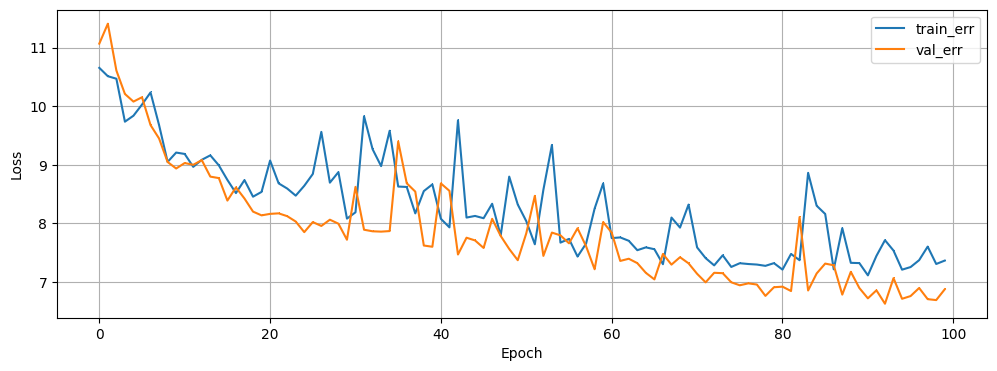

In [51]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### 4) 예측 및 평가

In [52]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 0s 5ms/step


In [53]:
# 평가
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

2.580778564868836
0.5399836745573298


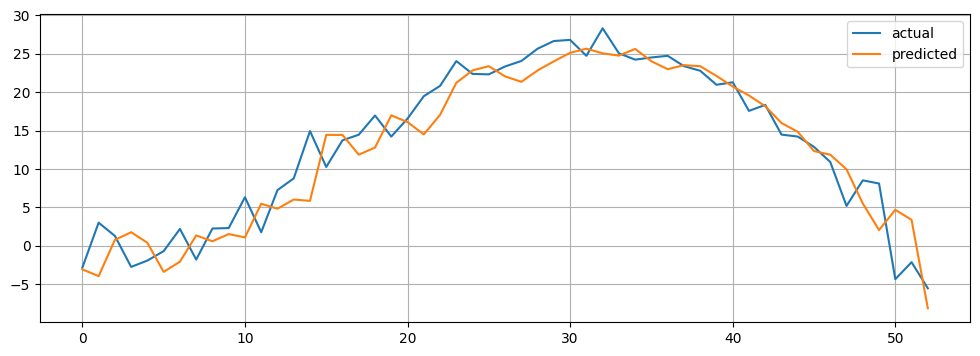

In [55]:
plt.figure(figsize = (12,4))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## (3)  실습 1

`-` RNN 레이어를 하나 더 추가...

In [57]:
clear_session()

model = Sequential([SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences=True),
                                      SimpleRNN(4),
                                          Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 8)              80        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 52        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 137 (548.00 Byte)
Trainable params: 137 (548.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.compile(optimizer = Adam(lr = 0.01), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 100, validation_split = .2).history

Epoch 1/100
6/6 [==============================] - 4s 116ms/step - loss: 293.2144 - val_loss: 387.0168
Epoch 2/100
6/6 [==============================] - 0s 36ms/step - loss: 283.8497 - val_loss: 372.7898
Epoch 3/100
6/6 [==============================] - 0s 24ms/step - loss: 273.1573 - val_loss: 356.3178
Epoch 4/100
6/6 [==============================] - 0s 28ms/step - loss: 261.0764 - val_loss: 339.0669
Epoch 5/100
6/6 [==============================] - 0s 31ms/step - loss: 248.5183 - val_loss: 322.3875
Epoch 6/100
6/6 [==============================] - 0s 29ms/step - loss: 237.2658 - val_loss: 308.3640
Epoch 7/100
6/6 [==============================] - 0s 25ms/step - loss: 227.8352 - val_loss: 297.9115
Epoch 8/100
6/6 [==============================] - 0s 33ms/step - loss: 221.3156 - val_loss: 289.8501
Epoch 9/100
6/6 [==============================] - 0s 33ms/step - loss: 216.1329 - val_loss: 284.1252
Epoch 10/100
6/6 [==============================] - 0s 33ms/step - loss: 212.7198

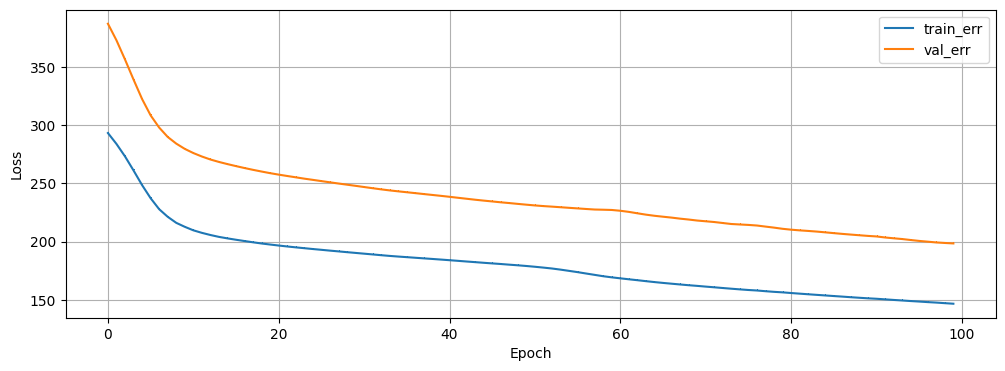

In [59]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

In [60]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 0s 6ms/step


In [62]:
# 평가
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

10.461073768535277
0.9029887280232256


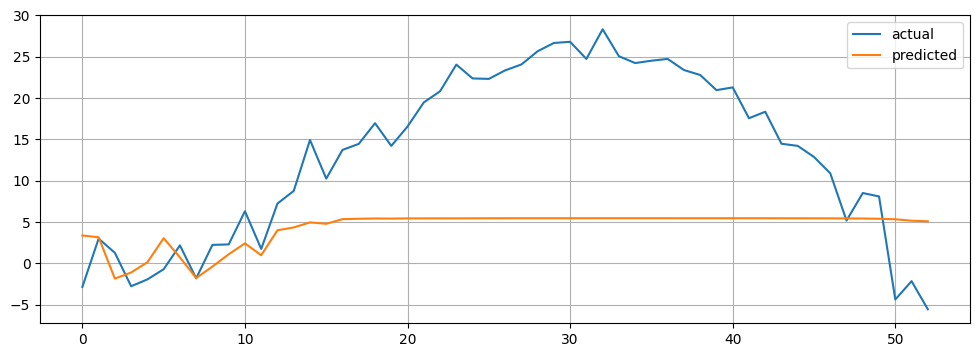

In [63]:
plt.figure(figsize = (12,4))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

`-` 성능이 더 떨어짐...

* 당연한 것임. 히든스테이트의 값을 계속 가져왔으니 train data에 오버피팅이 될 수 밖에 없음

`-` 근데 RNN layer를 2개 쓸거면 첫 번째 layer에서는 무조건 `return_sequences  = True`로 줘야함

*  왜? 시간의 흐름에 따라 순차적으로 두 번째 RNN layer가 학습해야되기 때문!!

## (4) 실습 2

`-` 위에 모델을 2개의 모델 정도 수정해보자

* model1 : RNN(8) + RNN(2) + output
* model2: RNN(8) + RNN(2)+ Dense(4) + output

In [90]:
clear_session()

model1 = Sequential([SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences=True),
                                      SimpleRNN(2),
                                          Dense(1)])

model2 = Sequential([SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences=True),
                                      SimpleRNN(2),
                                          Dense(4, activation = "tanh"),
                                          Dense(1)])

In [91]:
model1.compile(optimizer = Adam(0.01), loss = 'mse' )
model2.compile(optimizer = Adam(0.01), loss = 'mse' )

h1 = model1.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
h2 = model1.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history

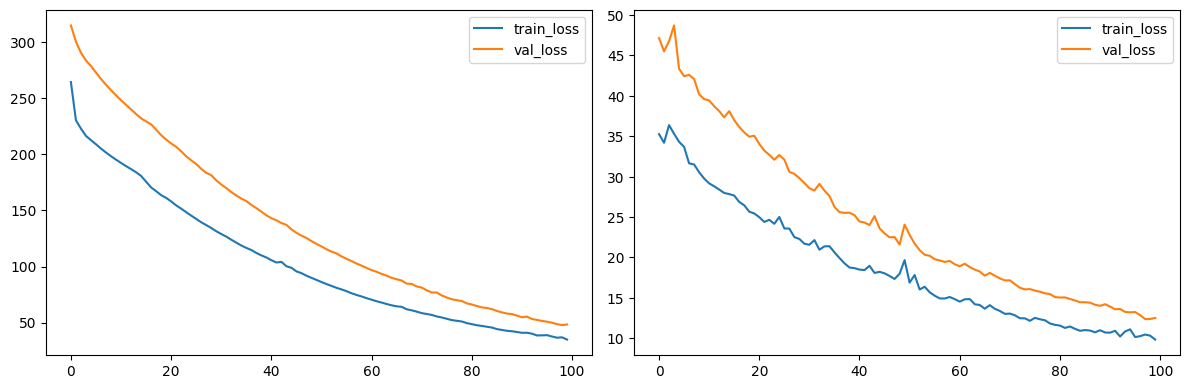

In [92]:
#| code-fold : true
fig, axes = plt.subplots(1,2, figsize = (12,4))

ax1, ax2 =axes

ax1.plot(h1["loss"], label = "train_loss")
ax1.plot(h1["val_loss"], label = "val_loss")
ax1.legend()

ax2.plot(h2["loss"], label = "train_loss")
ax2.plot(h2["val_loss"], label = "val_loss")
ax2.legend()

fig.tight_layout()
fig.show()

`-` 안정적인 폭은 `model1`이지만 전반적인 loss가 model2가 훨씬 작다.

In [93]:
# 예측
pred1 = model1.predict(x_val)
pred2 = model2.predict(x_val)

2/2 [==============================] - 0s 6ms/step


In [97]:
print(mean_absolute_error(y_val, pred1))
print(mean_absolute_error(y_val, pred2))

3.0550256566582155
14.10010453259718


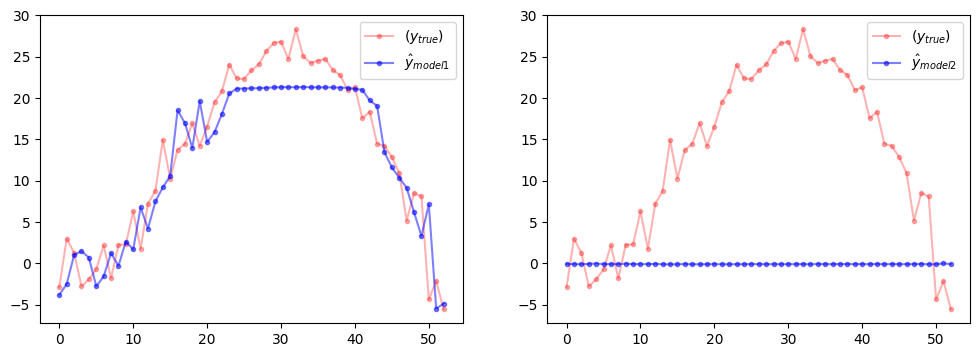

In [95]:
fig, axes = plt.subplots(1,2, figsize = (12, 4))

ax1, ax2 = axes

ax1.plot(y_val, ".-r" ,label = r"$(y_{true})$",alpha = 0.3)
ax1.plot(pred1, ".-b" ,label = r"$\hat {y}_{model1}$", alpha = 0.5)
ax1.legend()

ax2.plot(y_val, ".-r" ,label = r"$(y_{true})$",alpha = 0.3)
ax2.plot(pred2, ".-b" ,label = r"$\hat {y}_{model2}$", alpha = 0.5)
ax2.legend()
